<a href="https://colab.research.google.com/github/RuoyunMa/CS231N-Project/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following processing work refers to 
1. https://github.com/assassint2017/abdominal-multi-organ-segmentation/blob/master/data_perpare/get_data.py
2. https://colab.research.google.com/github/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/blob/master/Example_on_BRATS2018.ipynb#scrollTo=nNNtloQ9B3sA


**Attention:**

This notebook is composed by two sections, 'Some Trials' and 'Entire Process'. The section 'Some Trials' records our exploration on the original data, which should be skipped when reproducing this work.

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# import simpleITK
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 93kB/s 


In [0]:
import os
import shutil
from time import time

import numpy as np
import pandas as pd
import SimpleITK as sitk
import scipy.ndimage as ndimage

from matplotlib import pyplot as plt 
from skimage import transform 

In [4]:
# data path of 3D CT image and Label
ct_path = '/content/drive/Shared drives/CS231N project/data/CT'
label_path = '/content/drive/Shared drives/CS231N project/data/label'
print(ct_path)
print(label_path)

/content/drive/Shared drives/CS231N project/data/CT
/content/drive/Shared drives/CS231N project/data/label


In [276]:
# data path for saving new results
save_path = '/content/drive/Shared drives/CS231N project/data/processed'
print(save_path)

/content/drive/Shared drives/CS231N project/data/processed


### Section 0: Some Trials
Please skip this section when reproducing

#### Shape of each original sample: (m, 512, 512)
Statistics about m (shape[0]) are shown as follows.

In [0]:
ct_array_shape = []
for ct_file in os.listdir(ct_path):
  img_path = os.path.join(ct_path, ct_file)
  ct_array = sitk.GetArrayFromImage(sitk.ReadImage(img_path, sitk.sitkInt16))
  ct_array_shape.append(ct_array.shape)
  # print(ct_file, ct_array.shape)

In [0]:
shape0_list = [shape[0] for shape in ct_array_shape]
print("shape[0] mean: ", np.mean(shape0_list))
print("shape[0] std: ", np.std(shape0_list))
print("shape[0] max: ", np.max(shape0_list))
print("shape[0] min: ", np.min(shape0_list))

shape[0] mean:  448.6730769230769
shape[0] std:  259.4447637340058
shape[0] max:  987
shape[0] min:  74


#### Example of orginal data: image and label

In [5]:
print('Example of sample 0')
for ct_file in os.listdir(ct_path):
  # read image and label
  ct = sitk.ReadImage(os.path.join(ct_path, ct_file), sitk.sitkInt16)
  ct_array = sitk.GetArrayFromImage(ct)
  label = sitk.ReadImage(os.path.join(label_path, ct_file.replace('volume', 'labels')), sitk.sitkInt8)
  label_array = sitk.GetArrayFromImage(label)

  # check shape
  print('\nShape of Image and Label:')
  print('Image shape: ', ct_array.shape, '; Label shape: ', label_array.shape)

  # show the first horizontal slice array[0]
  # print the first array with non-zero labels
  label_array0 = label_array[0]
  ct_array0 = ct_array[0]
  for i in range(len(label_array0[0])):
    if np.sum(label_array0[i]):
      print('\nIndex of the second axis: ',i)
      print('Label array: ', label_array0[i])
      print('Image array: ', ct_array0[i])

      print('\nPrint corresponding ct values:')
      print('Label value: ', label_array0[i][label_array0[i]>0])
      print('Image value: ', ct_array0[i][label_array0[i]>0])
      break

  break

Example of sample 0

Shape of Image and Label:
Image shape:  (75, 512, 512) ; Label shape:  (75, 512, 512)

Index of the second axis:  172
Label array:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

#### Example: trial with sample 0 and sample 1

In [0]:
ct1 = sitk.ReadImage(os.path.join(ct_path,'volume-1.nii.gz'), sitk.sitkInt16)
ct1_array = sitk.GetArrayFromImage(ct1)
label1 = sitk.ReadImage(os.path.join(label_path,'labels-1.nii.gz'), sitk.sitkInt16)
label1_array = sitk.GetArrayFromImage(label1)

In [7]:
# spacing
print(ct.GetSpacing(),ct1.GetSpacing())
print(ct_array.shape, ct1_array.shape)

(0.703125, 0.703125, 5.0) (0.6757810115814209, 0.6757810115814209, 5.0)
(75, 512, 512) (123, 512, 512)


In [0]:
upper = 350
lower = -upper
slice_thickness = 3
down_scale = 0.5
expand_slice = 10

In [0]:
# zoom the image. zoom: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
# For CT image, use defaulte spline interpolation with order = 3, while set order = 0 (mute spline interpolation) for label, avoid breaking the boundary.
# return type: int

def zoom_ct_label(ct_array, label_array, ct, slice_thickness, down_scale):
  ct_array_zoom = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)
  label_array_zoom = ndimage.zoom(label_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=0)
  return ct_array_zoom, label_array_zoom

In [0]:
ct_array_zoom, label_array_zoom = zoom_ct_label(ct_array, label_array, ct, slice_thickness, down_scale)
ct1_array_zoom, label1_array_zoom = zoom_ct_label(ct1_array, label1_array, ct1, slice_thickness, down_scale)

In [89]:
print('shape of ct:', ct_array_zoom.shape, ' shape of label:', ct_array_zoom.shape)
print('shape of ct1:', ct1_array_zoom.shape, ' shape of label1:', ct1_array_zoom.shape)

shape of ct: (125, 256, 256)  shape of label: (125, 256, 256)
shape of ct1: (205, 256, 256)  shape of label1: (205, 256, 256)


In [0]:
# set values beyond the threshold as the threshold in ct array
def cut_threshold(ct_array, upper, lower):
  ct_array[ct_array > upper] = upper
  ct_array[ct_array < lower] = lower
  return ct_array

In [0]:
ct_array_zoom = cut_threshold(ct_array_zoom, upper, lower)
ct1_array_zoom = cut_threshold(ct1_array_zoom, upper, lower)

In [0]:
# cut off no-label slices
def cut_no_label(ct_array, label_array, expand_slice):

  # find the slices containing the target organs (label = 1 (liver) or 4 (kidney))
  mask = np.where((label_array==1)|(label_array==4), 1, 0)
  z = np.any(mask, axis=(1, 2))   
  start_slice, end_slice = np.where(z)[0][[0, -1]]
  # print(start_slice, end_slice)

  # expand slices upward and downward, reserve expand_slice more slices at the up and down boundaries
  # make sure not extending the original shape
  start_slice = max(0, start_slice - expand_slice) 
  end_slice = min(ct_array.shape[0] - 1, end_slice + expand_slice)

  # cut off the slices out of boundaries
  new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
  new_label_array = label_array[start_slice:end_slice + 1, :, :]

  return new_ct_array, new_label_array

In [0]:
new_ct_array, new_label_array = cut_no_label(ct_array_zoom, label_array_zoom, expand_slice)
new_ct1_array, new_label1_array = cut_no_label(ct1_array_zoom, label1_array_zoom, expand_slice)

In [17]:
# shape before cutting off no target organ parts
print(new_ct_array.shape)
print(new_ct1_array.shape)

(125, 256, 256)
(205, 256, 256)


In [0]:
def data_process(id, upper, lower, slice_thickness, down_scale, expand_slice):
  print('Processing Sample No.', id)

  # read data
  curr_ct = sitk.ReadImage(os.path.join(ct_path,'volume-'+str(id)+'.nii.gz'), sitk.sitkInt16)
  curr_ct_array = sitk.GetArrayFromImage(curr_ct)
  curr_label = sitk.ReadImage(os.path.join(label_path,'labels-'+str(id)+'.nii.gz'), sitk.sitkInt16)
  curr_label_array = sitk.GetArrayFromImage(curr_label)
  # print('read data done')

  # zoom image
  curr_ct_array_zoom, curr_label_array_zoom = zoom_ct_label(curr_ct_array, curr_label_array, curr_ct, slice_thickness, down_scale)
  # print('zoom image done')

  # check threshold
  curr_ct_array_zoom = cut_threshold(curr_ct_array_zoom, upper, lower)
  # print('check threshold done')

  # cut off no-label slices
  new_ct_array, new_label_array = cut_no_label(curr_ct_array_zoom, curr_label_array_zoom, expand_slice)
  # print('cut off no-label done')

  return new_ct_array, new_label_array

#### New shape test (after cutting off no target organ parts)

In [126]:
new_ct_array_shape = []
for id in range(140):
  new_ct_array, new_label_array = data_process(id, upper, lower, slice_thickness, down_scale, expand_slice)
  new_ct_array_shape.append(new_ct_array)

Processing Sample No. 0
Processing Sample No. 1
Processing Sample No. 2
Processing Sample No. 3
Processing Sample No. 4
Processing Sample No. 5
Processing Sample No. 6
Processing Sample No. 7
Processing Sample No. 8
Processing Sample No. 9
Processing Sample No. 10
Processing Sample No. 11
Processing Sample No. 12
Processing Sample No. 13
Processing Sample No. 14
Processing Sample No. 15
Processing Sample No. 16
Processing Sample No. 17
Processing Sample No. 18
Processing Sample No. 19
Processing Sample No. 20
Processing Sample No. 21
Processing Sample No. 22
Processing Sample No. 23
Processing Sample No. 24
Processing Sample No. 25
Processing Sample No. 26
Processing Sample No. 27
Processing Sample No. 28
Processing Sample No. 29
Processing Sample No. 30
Processing Sample No. 31
Processing Sample No. 32
Processing Sample No. 33
Processing Sample No. 34
Processing Sample No. 35
Processing Sample No. 36
Processing Sample No. 37
Processing Sample No. 38
Processing Sample No. 39
Processing

new shape[0] mean:  78.65
new shape[0] median:  83.0
new shape[0] std:  16.3116632242962
new shape[0] max:  106
new shape[0] min:  25


(array([ 3.,  6.,  6.,  3.,  1., 12., 32., 46., 26.,  5.]),
 array([ 25. ,  33.1,  41.2,  49.3,  57.4,  65.5,  73.6,  81.7,  89.8,
         97.9, 106. ]),
 <a list of 10 Patch objects>)

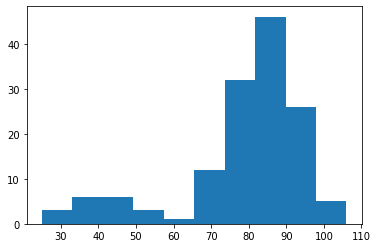

In [154]:
new_shape0_list = [array.shape[0] for array in new_ct_array_shape]
print("new shape[0] mean: ", np.mean(new_shape0_list))
print("new shape[0] median: ", np.median(new_shape0_list))
print("new shape[0] std: ", np.std(new_shape0_list))
print("new shape[0] max: ", np.max(new_shape0_list))
print("new shape[0] min: ", np.min(new_shape0_list))
plt.hist(new_shape0_list)

In [162]:
# rescale to around mean
target_height = 80 

min_array = new_ct_array_shape[np.argmin(new_shape0_list)]  # 25
max_array = new_ct_array_shape[np.argmax(new_shape0_list)]  # 106

print('min_array.shape', min_array.shape)
print('max_array.shape', max_array.shape)

min_array_zoom = ndimage.zoom(min_array, (target_height/min_array.shape[0], 1, 1), order=3)
max_array_zoom = ndimage.zoom(max_array, (target_height/max_array.shape[0], 1, 1), order=3)

print('min_array_zoom.shape', min_array_zoom.shape)
print('max_array_zoom.shape', max_array_zoom.shape)

min_array.shape (25, 256, 256)
max_array.shape (106, 256, 256)
min_array_zoom.shape (80, 256, 256)
max_array_zoom.shape (80, 256, 256)


min_array.shape (25, 256, 256)
max_array.shape (106, 256, 256)


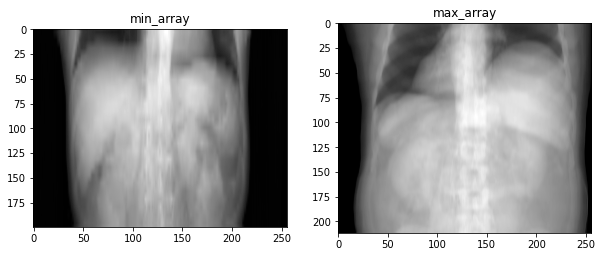

In [224]:
min_array_sum = min_array.sum(axis=1)
max_array_sum = max_array.sum(axis=1)

print('min_array.shape', min_array.shape)
print('max_array.shape', max_array.shape)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('min_array')
plt.imshow(transform.rescale(min_array_sum[::-1][:], [8,1]), cmap='gray')
plt.subplot(1,2,2)
plt.title('max_array')
plt.imshow(transform.rescale(max_array_sum[::-1][:], [2,1]), cmap='gray')

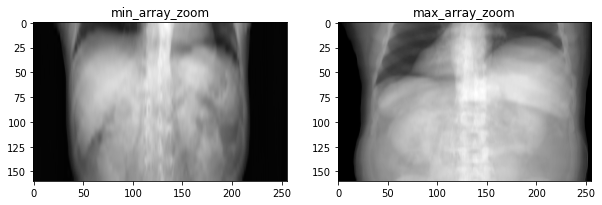

In [225]:
min_array_zoom_sum = min_array_zoom.sum(axis=1)
max_array_zoom_sum = max_array_zoom.sum(axis=1)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('min_array_zoom')
plt.imshow(transform.rescale(min_array_zoom_sum[::-1][:], [2,1]), cmap='gray')
plt.subplot(1,2,2)
plt.title('max_array_zoom')
plt.imshow(transform.rescale(max_array_zoom_sum[::-1][:], [2,1]), cmap='gray')

#### Example of projection (Sample 1)
* CT: Before cutting off no target organ parts

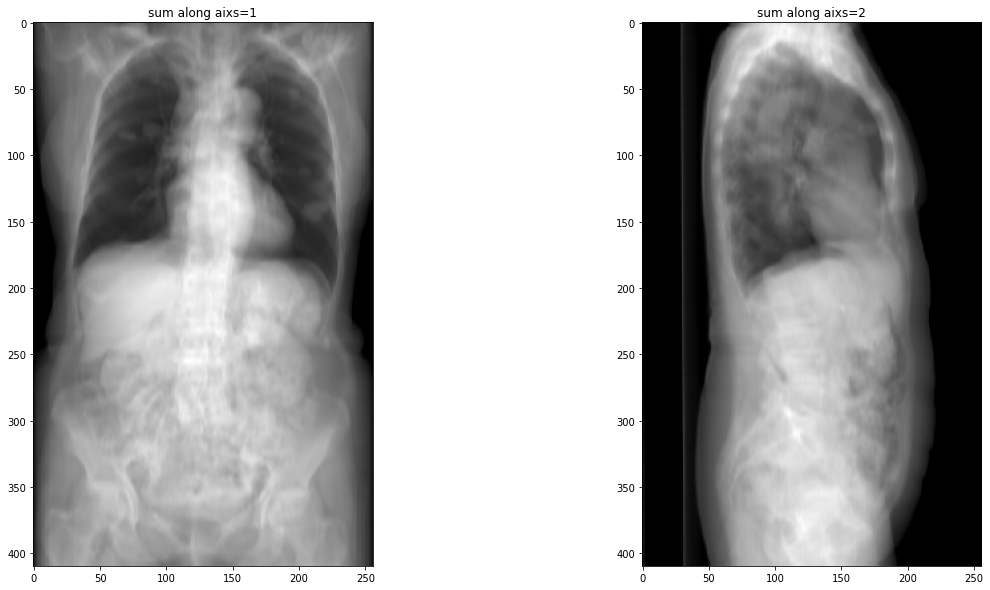

In [229]:
ct1_axis1_sum = new_ct1_array.sum(axis=1)
ct1_axis2_sum = new_ct1_array.sum(axis=2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('sum along aixs=1')
plt.imshow(transform.rescale(ct1_axis1_sum[::-1][:], [2,1]), cmap='gray')

plt.subplot(1,2,2)
plt.title('sum along aixs=2')
plt.imshow(transform.rescale(ct1_axis2_sum[::-1][:], [2,1]), cmap='gray')

* CT: After cutting off no target organ parts

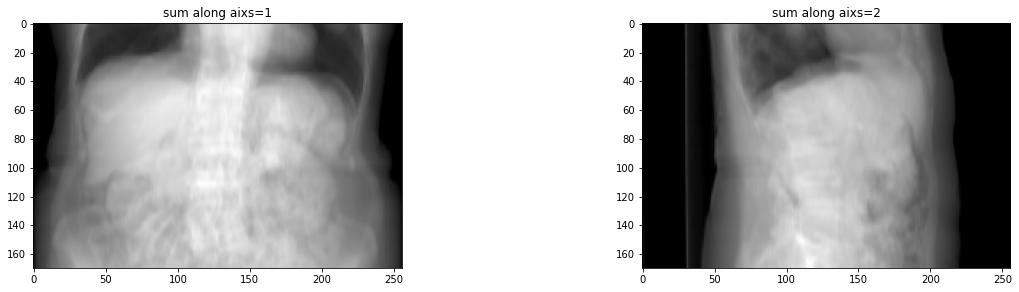

In [236]:
new_ct1_axis1_sum = new_ct_array1.sum(axis=1)
new_ct1_axis2_sum = new_ct_array1.sum(axis=2)

plt.figure(figsize=(20,4.5))
plt.subplot(1,2,1)
plt.title('sum along aixs=1')
plt.imshow(transform.rescale(new_ct1_axis1_sum[::-1][:], [2,1]), cmap='gray')

plt.subplot(1,2,2)
plt.title('sum along aixs=2')
plt.imshow(transform.rescale(new_ct1_axis2_sum[::-1][:], [2,1]), cmap='gray')

* Label: After processing along axis = 1

In [170]:
# rescale to around mean
target_height = 80 

new_ct_array1, new_lb_array1 = data_process(1, upper, lower, slice_thickness, down_scale, expand_slice)

new_ct_array1_zoom = ndimage.zoom(new_ct_array1, (target_height/new_ct_array1.shape[0], 1, 1), order=3)
new_lb_array1_zoom = ndimage.zoom(new_lb_array1, (target_height/new_lb_array1.shape[0], 1, 1), order=0)

print(new_ct_array1_zoom.shape, new_lb_array1_zoom.shape)

Processing Sample No. 1
(80, 256, 256) (80, 256, 256)


In [0]:
# process along axis = 1
depth_axis1_organ1 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[2]])
thick_axis1_organ1 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[2]])
depth_axis1_organ4 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[2]])
thick_axis1_organ4 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[2]])

for i in range(new_lb_array1_zoom.shape[0]):
  for j in range(new_lb_array1_zoom.shape[2]):
    temp_array = new_lb_array1_zoom[i, :, j]
    
    # liver
    id_list1 = np.where(temp_array == 1)[0]
    depth_axis1_organ1[i, j] = id_list1[0] if len(id_list1) else new_lb_array1_zoom.shape[2]
    thick_axis1_organ1[i, j] = len(id_list1)

    # kidney
    id_list4 = np.where(temp_array == 4)[0]
    depth_axis1_organ4[i, j] = id_list4[0] if len(id_list4) else new_lb_array1_zoom.shape[2]
    thick_axis1_organ4[i, j] = len(id_list4)


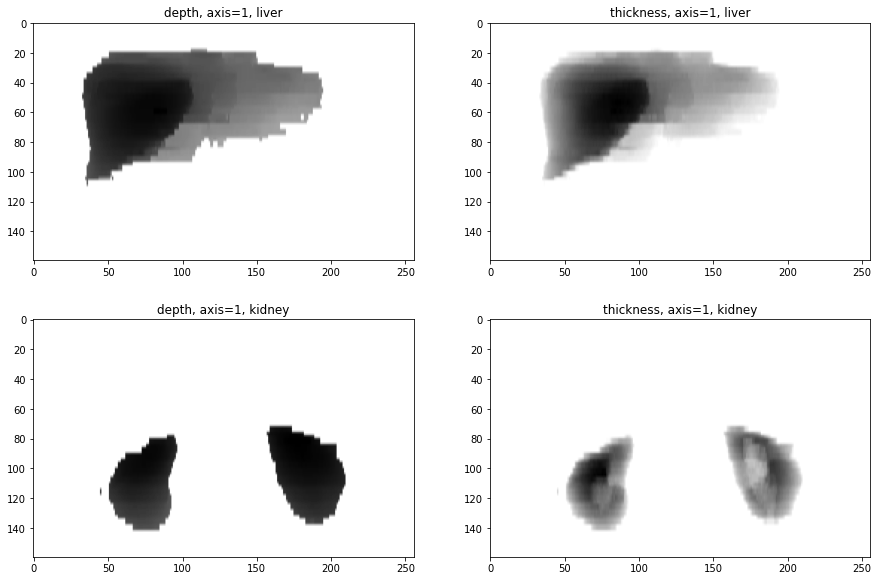

In [295]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.title('depth, axis=1, liver')
plt.imshow(transform.rescale(depth_axis1_organ1[::-1][:], [2,1]), cmap='gray')

plt.subplot(2, 2, 2)
plt.title('thickness, axis=1, liver')
plt.imshow(transform.rescale((thick_axis1_organ1.shape[1] - thick_axis1_organ1)[::-1][:], [2,1]), cmap='gray')

plt.subplot(2,2,3)
plt.title('depth, axis=1, kidney')
plt.imshow(transform.rescale(depth_axis1_organ4[::-1][:], [2,1]), cmap='gray')

plt.subplot(2,2,4)
plt.title('thickness, axis=1, kidney')
plt.imshow(transform.rescale((thick_axis1_organ4.shape[1] - thick_axis1_organ4)[::-1][:], [2,1]), cmap='gray')

* Label: After processing along axis = 2

In [0]:
# process along axis = 2
depth_axis2_organ1 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[1]])
thick_axis2_organ1 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[1]])
depth_axis2_organ4 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[1]])
thick_axis2_organ4 = np.zeros([new_lb_array1_zoom.shape[0], new_lb_array1_zoom.shape[1]])

for i in range(new_lb_array1_zoom.shape[0]):
  for j in range(new_lb_array1_zoom.shape[1]):
    temp_array = new_lb_array1_zoom[i, j, :]
    
    # liver
    id_list1 = np.where(temp_array == 1)[0]
    depth_axis2_organ1[i, j] = id_list1[0] if len(id_list1) else new_lb_array1_zoom.shape[2]
    thick_axis2_organ1[i, j] = len(id_list1)

    # kidney
    id_list4 = np.where(temp_array == 4)[0]
    depth_axis2_organ4[i, j] = id_list4[0] if len(id_list4) else new_lb_array1_zoom.shape[2]
    thick_axis2_organ4[i, j] = len(id_list4)

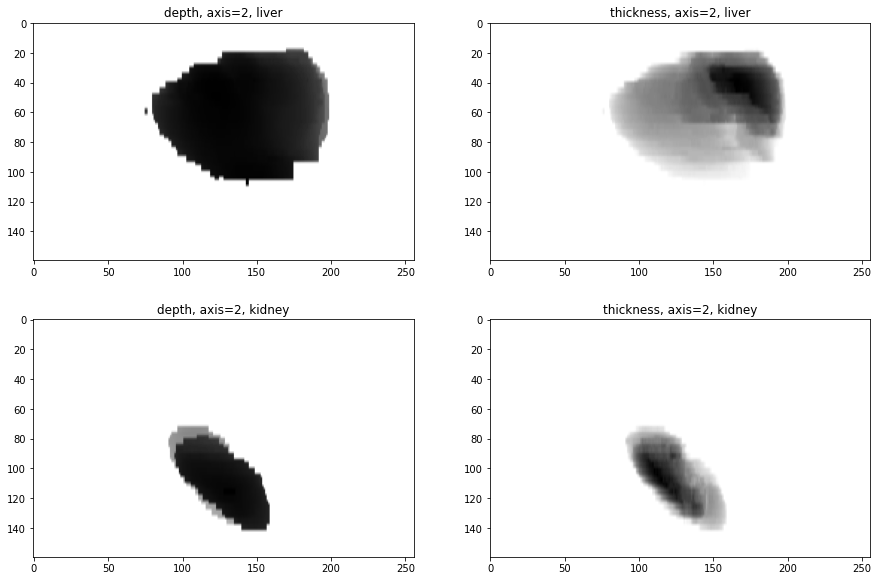

In [296]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.title('depth, axis=2, liver')
plt.imshow(transform.rescale(depth_axis2_organ1[::-1][:], [2,1]), cmap='gray')

plt.subplot(2, 2, 2)
plt.title('thickness, axis=2, liver')
plt.imshow(transform.rescale((thick_axis2_organ1.shape[1] - thick_axis2_organ1)[::-1][:], [2,1]), cmap='gray')

plt.subplot(2,2,3)
plt.title('depth, axis=2, kidney')
plt.imshow(transform.rescale(depth_axis2_organ4[::-1][:], [2,1]), cmap='gray')

plt.subplot(2,2,4)
plt.title('thickness, axis=2, kidney')
plt.imshow(transform.rescale((thick_axis2_organ4.shape[1] - thick_axis2_organ4)[::-1][:], [2,1]), cmap='gray')

### Section 1: Entire Process

In [0]:
upper = 350
lower = -upper
slice_thickness = 3
down_scale = 0.5
expand_slice = 10

target_height = 80 

In [0]:
# function collection

# zoom the image. zoom: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
def zoom_ct_label(ct_array, label_array, ct, slice_thickness, down_scale):
  """
  For CT image, use defaulte spline interpolation with order = 3, while set order = 0 (mute spline interpolation) for label, avoid breaking the boundary.
  return type: int
  """
  ct_array_zoom = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)
  label_array_zoom = ndimage.zoom(label_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=0)
  return ct_array_zoom, label_array_zoom


# set values beyond the threshold as the threshold in ct array
def cut_threshold(ct_array, upper, lower):
  ct_array[ct_array > upper] = upper
  ct_array[ct_array < lower] = lower
  return ct_array


# cut off no-label slices
def cut_no_label(ct_array, label_array, expand_slice):

  # find the slices containing the target organs (label = 1 (liver) or 4 (kidney))
  mask = np.where((label_array==1)|(label_array==4), 1, 0)
  z = np.any(mask, axis=(1, 2))   
  start_slice, end_slice = np.where(z)[0][[0, -1]]
  # print(start_slice, end_slice)

  # expand slices upward and downward, reserve expand_slice more slices at the up and down boundaries
  # make sure not extending the original shape
  start_slice = max(0, start_slice - expand_slice) 
  end_slice = min(ct_array.shape[0] - 1, end_slice + expand_slice)

  # cut off the slices out of boundaries
  new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
  new_label_array = label_array[start_slice:end_slice + 1, :, :]

  return new_ct_array, new_label_array


In [0]:
def data_process_3D(id, upper, lower, slice_thickness, down_scale, expand_slice):

  # read data
  curr_ct = sitk.ReadImage(os.path.join(ct_path,'volume-'+str(id)+'.nii.gz'), sitk.sitkInt16)
  curr_ct_array = sitk.GetArrayFromImage(curr_ct)
  curr_label = sitk.ReadImage(os.path.join(label_path,'labels-'+str(id)+'.nii.gz'), sitk.sitkInt16)
  curr_label_array = sitk.GetArrayFromImage(curr_label)

  # zoom image
  curr_ct_array_zoom, curr_label_array_zoom = zoom_ct_label(curr_ct_array, curr_label_array, curr_ct, slice_thickness, down_scale)

  # check threshold
  curr_ct_array_zoom = cut_threshold(curr_ct_array_zoom, upper, lower)

  # cut off no-label slices
  new_ct_array, new_label_array = cut_no_label(curr_ct_array_zoom, curr_label_array_zoom, expand_slice)

  # zoom to the same size along axis=0
  new_ct_array_zoom = ndimage.zoom(new_ct_array, (target_height/new_ct_array.shape[0], 1, 1), order=3)
  new_label_array_zoom = ndimage.zoom(new_label_array, (target_height/new_label_array.shape[0], 1, 1), order=0)

  return new_ct_array_zoom, new_label_array_zoom

In [0]:
# label process along axis
def label_process_axis1(new_label_array, axis):
  depth_organ1 = np.zeros([80, 256])
  thick_organ1 = np.zeros([80, 256])
  depth_organ4 = np.zeros([80, 256])
  thick_organ4 = np.zeros([80, 256])

  for i in range(new_label_array.shape[0]):
    for j in range(new_label_array.shape[2]):
      if axis == 1:
        temp_array = new_label_array[i, :, j]
      elif axis == 2:
        temp_array = new_label_array[i, j, :]

      # liver
      id_list1 = np.where(temp_array == 1)[0]
      depth_organ1[i, j] = id_list1[0] if len(id_list1) else new_label_array.shape[2]
      thick_organ1[i, j] = len(id_list1)
      # kidney
      id_list4 = np.where(temp_array == 4)[0]
      depth_organ4[i, j] = id_list4[0] if len(id_list4) else new_label_array.shape[2]
      thick_organ4[i, j] = len(id_list4)
  
  return depth_organ1.reshape(80*256), thick_organ1.reshape(80*256), depth_organ4.reshape(80*256), thick_organ4.reshape(80*256)

In [272]:
outputDict = {
    'new_ct_axis1': [], 'new_ct_axis2': [],
    'depth_organ1_a1': [], 'thick_organ1_a1': [], 'depth_organ4_a1': [], 'thick_organ4_a1': [],
    'depth_organ1_a2': [], 'thick_organ1_a2': [], 'depth_organ4_a2': [], 'thick_organ4_a2': []
}

for i in range(140):
  # 3D process
  new_ct_array, new_label_array = data_process_3D(i, upper, lower, slice_thickness, down_scale, expand_slice)

  # generate 2D CT image
  new_ct_axis1 = new_ct_array.sum(axis=1).reshape(80*256)
  new_ct_axis2 = new_ct_array.sum(axis=2).reshape(80*256)

  # generate 2D depth and thickness label in axis=1
  depth_organ1_a1, thick_organ1_a1, depth_organ4_a1, thick_organ4_a1 = label_process_axis1(new_label_array, axis=1)

  # generate 2D depth and thickness label in axis=2
  depth_organ1_a2, thick_organ1_a2, depth_organ4_a2, thick_organ4_a2 = label_process_axis1(new_label_array, axis=2)

  # append results
  outputDict['new_ct_axis1'].append(new_ct_axis1)
  outputDict['new_ct_axis2'].append(new_ct_axis2)
  outputDict['depth_organ1_a1'].append(depth_organ1_a1)
  outputDict['thick_organ1_a1'].append(thick_organ1_a1)
  outputDict['depth_organ4_a1'].append(depth_organ4_a1)
  outputDict['thick_organ4_a1'].append(thick_organ4_a1)
  outputDict['depth_organ1_a2'].append(depth_organ1_a2)
  outputDict['thick_organ1_a2'].append(thick_organ1_a2)
  outputDict['depth_organ4_a2'].append(depth_organ4_a2)
  outputDict['thick_organ4_a2'].append(thick_organ4_a2)

  print('Processing Done, No.', i)


Processing Done, No. 0
Processing Done, No. 1
Processing Done, No. 2
Processing Done, No. 3
Processing Done, No. 4
Processing Done, No. 5
Processing Done, No. 6
Processing Done, No. 7
Processing Done, No. 8
Processing Done, No. 9
Processing Done, No. 10
Processing Done, No. 11
Processing Done, No. 12
Processing Done, No. 13
Processing Done, No. 14
Processing Done, No. 15
Processing Done, No. 16
Processing Done, No. 17
Processing Done, No. 18
Processing Done, No. 19
Processing Done, No. 20
Processing Done, No. 21
Processing Done, No. 22
Processing Done, No. 23
Processing Done, No. 24
Processing Done, No. 25
Processing Done, No. 26
Processing Done, No. 27
Processing Done, No. 28
Processing Done, No. 29
Processing Done, No. 30
Processing Done, No. 31
Processing Done, No. 32
Processing Done, No. 33
Processing Done, No. 34
Processing Done, No. 35
Processing Done, No. 36
Processing Done, No. 37
Processing Done, No. 38
Processing Done, No. 39
Processing Done, No. 40
Processing Done, No. 41
Pr

In [0]:
# save files
# generate 10 csv files, each file is a 2D array whose shape is (140, 80*256)

for key in outputDict:
  np.savetxt(os.path.join(save_path, str(key)+'.csv'), outputDict[key], fmt='%d', delimiter=',')


In [0]:
# check. Read processed data

df = pd.read_csv(os.path.join(save_path, 'depth_organ1_a1.csv'), header=None)
array = df.to_numpy().reshape(140, 80, 256)

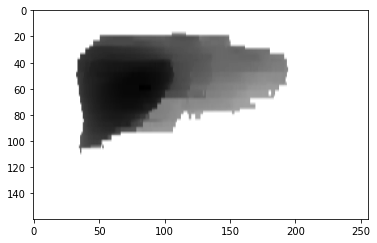

In [308]:
plt.imshow(transform.rescale(array[1][::-1][:], [2,1]), cmap='gray')